In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import h5py 

### Introduction

In this notebook we use a k-means algorithm to compress an image. 

The basic idea is the following: 

**Memory usage for a RGB image**

Consider a RGB color image comprised of ($N_w \times N_h$) pixels, where $N_w$ and $N_h$ are the width and height of the image in pixels. The color at each pixel is encoded by a three-tuple of integers $\vec c = (c_1, c_2, c_3) \in \{0, ..., 255\}^3$ corresponding to the amount of red, green, and blue at that particular pixel.

To store an integer $c_i \in \{0, ..., 255\}$ we need 8 bit, since $2^8 = 256$. This means for each pixel we need 24 bit (8 for red, 8 for green, 8 for blue). To store a RGB image with $N = N_w \times N_h$ pixels, we thus need to store

\begin{align}
    M &= N_w \cdot N_h \cdot 24 \mathrm{bit}.
\end{align}

**Image compression via k-means**

To compress a RGB image, we reduce the image to a given number of $K$ colors. We use the k-means algorithm for this, by identifying $K$ clusters for the set of $ N_w \cdot N_h$ three-dimensional color vectors defined by the image.

The algorithm then gives us $K$ colors (= cluster centroids in three-dimensional Euclidean space, chosen optimally for the given color distribution in the image), and maps every pixel to one of the colors (= maps every point in three-dimensional Euclidean space to one of the $K$ clusters).

The compressed image is then comprised of the following two sets:

1. The $K$ cluster centroids, i.e. $K$ tuples $\vec c = (c_1, c_2, c_3) \in \{0, ..., 255\}^3$, and 
2. an integer in $\{0, ..., K-1\}$ for each pixel, which tells us which of the $K$ colors this pixel should have.

If $K= 2^6 = 64$, then to store the number $\{0,...,K-1\}=\{0,...,63\}$ from point 2 above we need 6 bit. Thus, to specify the colors for the full image we need 

\begin{align}
    M &= N_w \cdot N_h \cdot 6 \mathrm{bit},
\end{align}

which is only 1/4 of the original image (for $K/(N_w \cdot N_h) \ll 1$ which easily holds for a typical image and $K$ of the order 50-100, the storage needed for the cluster centroids, is small compared to the pixel data so that the space needed for point 1 above is not important).

### Import the module

The k-means algorithm is implemented in the file k_means.py in this folder,
which we import now:

In [2]:
from k_means import *
# k_means contains three classes:
# - k_means: k-means algorithm
# - k_means_parallel: parallelized version of k-means
# - image_compression: image compression based on k-means

### Load and show sample image

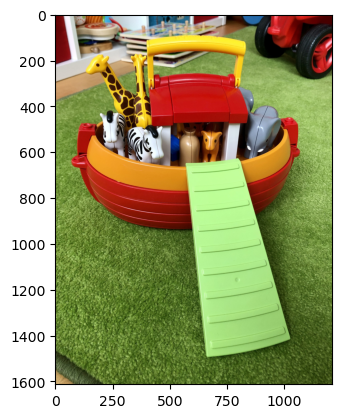

In [3]:
filename ='sample.JPG'
image = mpimg.imread(filename)
plt.imshow(image);

### Compress image

K = 2 finished. Runtime 16.8 seconds


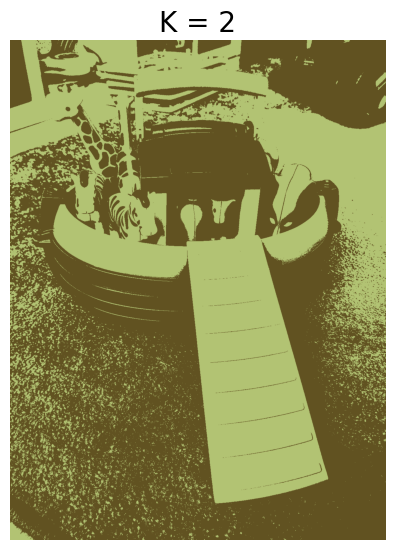

K = 3 finished. Runtime 25.7 seconds


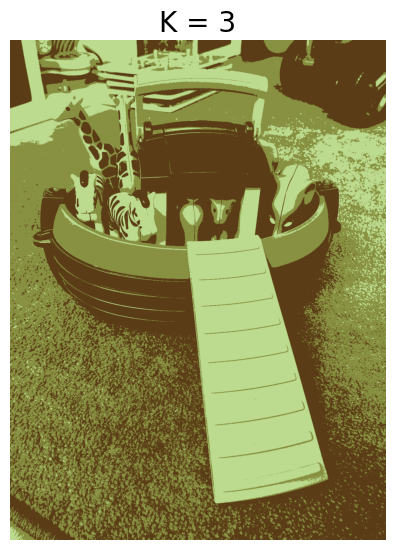

K = 4 finished. Runtime 39.8 seconds


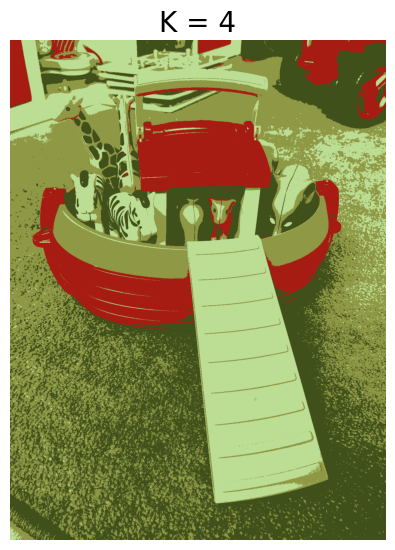

K = 5 finished. Runtime 32.3 seconds


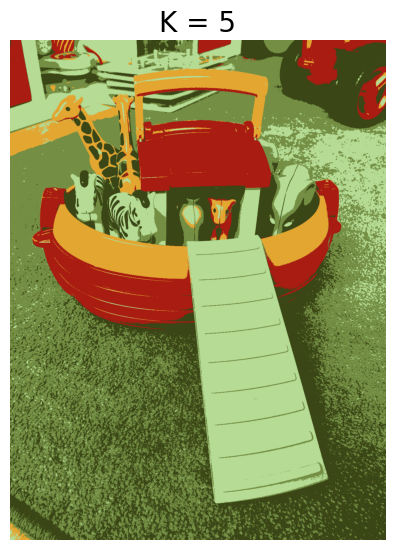

K = 6 finished. Runtime 47.9 seconds


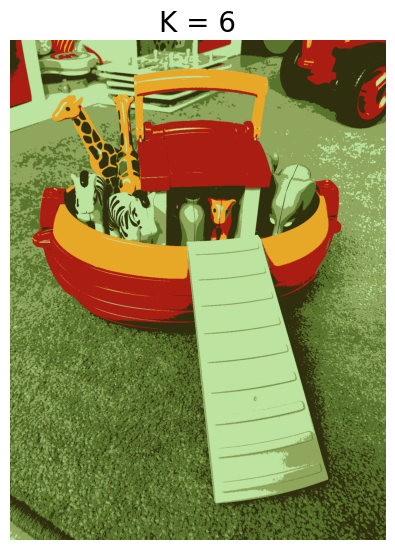

K = 8 finished. Runtime 40.7 seconds


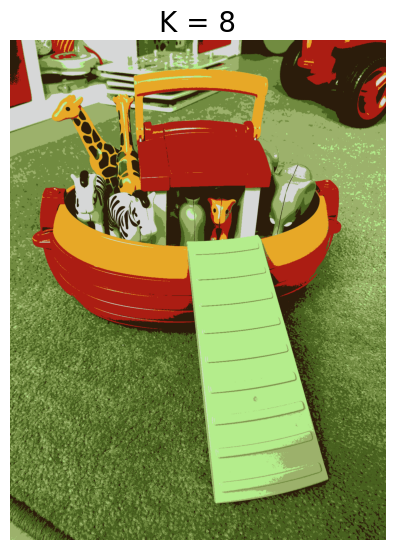

K = 16 finished. Runtime 152.8 seconds


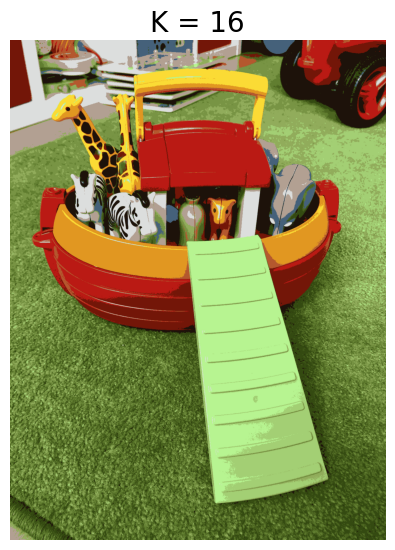

K = 64 finished. Runtime 1157.5 seconds


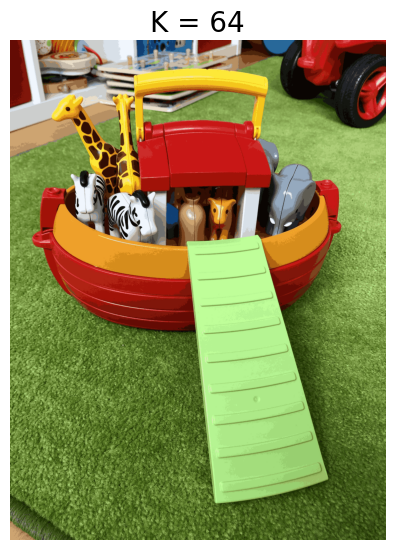

In [4]:
Ks = np.array([2,3,4,5,6,8,16,64],dtype=int)
N_cores = 4 # we run 4 cores in parallel
N_minimization = 4 # for each K, we take the best of 4 compression attempts

ic = image_compression() # instantiate compression algorithm

compressed_image_dictionaries = {}
for i,K in enumerate(Ks): 
    #
    title = 'K = {0}'.format(K) # title for plot
    filename = 'sample_K_{0}.jpg'.format(K) # filename for plot
    #
    print(title,end='\r')
    #
    starting_time = time.time()
    compressed_image_dictionaries[K] = ic.compress_image(image=image,
                                                K=K,
                                                N_cores=N_cores,
                                                N_minimization=N_minimization)
    finishing_time = time.time()
    runtime = finishing_time - starting_time
    compressed_image_dictionaries[K]['runtime'] = runtime
    #
    print("K = {0} finished. Runtime {1:3.1f} seconds".format(K,runtime))
    #
    image_recovered = ic.decompress_image(plot=True,
                                          title=title,
                                          filename=filename,
                                          **compressed_image_dictionaries[K])
    



### Save results to disk

We store the data in the hdf5 file format

In [5]:
with h5py.File('sample_compressed.h5', 'w') as hf:
    for K, results in compressed_image_dictionaries.items():
        hf0 = hf.create_group(str(K))
        for key, value in results.items():
            if len(np.shape(value)) == 0: 
                compression = None # scalar data does not support compression
            else:
                compression = 'lzf'
            hf0.create_dataset(name=str(key),data=value,
                              compression=compression)